--- Running Baseline ---
Baseline Overall Accuracy: 0.567
--- Running Shuffle ---
Shuffle Overall Accuracy: 0.061
--- Running Noise20% ---
Noise20% Overall Accuracy: 0.505
--- Running Perturbation ---
Perturbation Overall Accuracy: 0.474


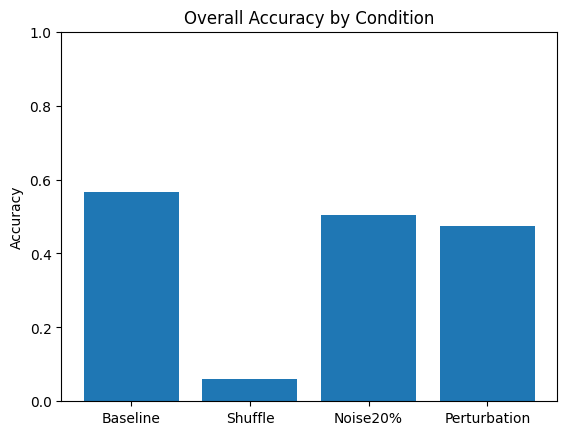

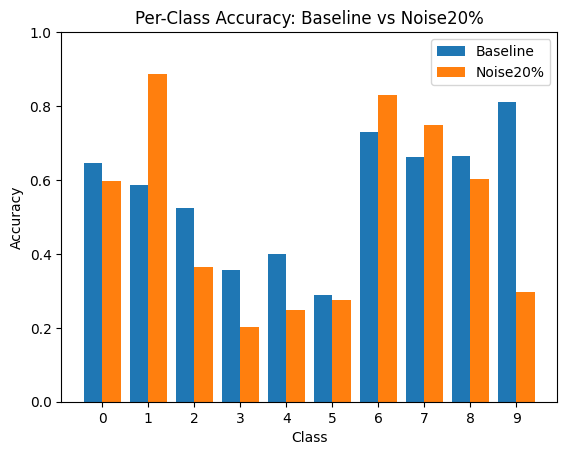

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict

# ------------------------------
# 1. 모델 정의
# ------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64*8*8, 256)
        self.fc2   = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------
# 2. 데이터셋 로딩 함수
# ------------------------------
def get_dataloaders(transform, shuffle_labels=False, noise_frac=0.0):
    base = torchvision.datasets.CIFAR10
    # 학습용 데이터셋
    train_ds = base(root='./data', train=True, download=True, transform=transform)
    # (1) 라벨 셔플
    if shuffle_labels:
        random.shuffle(train_ds.targets)
    # (2) 라벨 노이즈
    if noise_frac > 0:
        n = len(train_ds.targets)
        num_noisy = int(noise_frac * n)
        idxs = random.sample(range(n), num_noisy)
        for i in idxs:
            orig = train_ds.targets[i]
            choices = list(range(10)); choices.remove(orig)
            train_ds.targets[i] = random.choice(choices)
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)

    # 테스트용 데이터셋 (ToTensor + Normalize 포함)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    test_ds = base(root='./data', train=False, download=True, transform=test_transform)
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False, num_workers=4)
    return train_loader, test_loader

# ------------------------------
# 3. 학습 & 평가 함수
# ------------------------------
def train(model, loader, device):
    model.train()
    optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    crit = nn.CrossEntropyLoss()
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optim.zero_grad()
        loss = crit(model(inputs), labels)
        loss.backward(); optim.step()


def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    cls_correct = defaultdict(int)
    cls_total   = defaultdict(int)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)
            for p, t in zip(preds, labels):
                if p == t:
                    cls_correct[int(t)] += 1
                cls_total[int(t)]   += 1
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    overall = correct / total
    per_cls = {c: cls_correct[c] / cls_total[c] for c in range(10)}
    return overall, per_cls

# ------------------------------
# 4. 메인 실행: 실험 루프
# ------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 공통 transform (baseline / shuffle / noise)
    base_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),
                             (0.2023,0.1994,0.2010))
    ])
    # Input Perturbation 전용
    pert_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),
                             (0.2023,0.1994,0.2010))
    ])

    conditions = {
        'Baseline':      (base_transform, False, 0.0),
        'Shuffle':       (base_transform, True,  0.0),
        'Noise20%':      (base_transform, False, 0.2),
        'Perturbation':  (pert_transform,  False, 0.0),
    }

    results = {}
    for name, (tfm, shuffle, noise) in conditions.items():
        print(f'--- Running {name} ---')
        train_loader, test_loader = get_dataloaders(tfm, shuffle, noise)
        net = SimpleCNN().to(device)
        train(net, train_loader, device)
        ov, pc = evaluate(net, test_loader, device)
        results[name] = (ov, pc)
        print(f'{name} Overall Accuracy: {ov:.3f}')

    # ------------------------------
    # 5. 결과 시각화
    # ------------------------------
    # (1) Overall bar chart
    names = list(results.keys())
    overalls = [results[n][0] for n in names]

    plt.figure()
    plt.bar(names, overalls)
    plt.ylabel('Accuracy')
    plt.title('Overall Accuracy by Condition')
    plt.ylim(0,1)
    plt.show()

    # (2) 클래스별 비교 (Baseline vs Noise20%)
    cls = list(range(10))
    base_cls  = [results['Baseline'][1][c] for c in cls]
    noise_cls = [results['Noise20%'][1][c] for c in cls]

    plt.figure()
    x = cls
    plt.bar([i-0.2 for i in x], base_cls,  width=0.4, label='Baseline')
    plt.bar([i+0.2 for i in x], noise_cls, width=0.4, label='Noise20%')
    plt.xticks(x, cls)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Per-Class Accuracy: Baseline vs Noise20%')
    plt.ylim(0,1)
    plt.show()
